# Creating a Correlation Graph for A and B Channel Data

Purpose is to create a 4 by 4 grid of correlation plots of each sensor

- X is B PM2.5_atm, Y is A Pm2.5_atm
- 24 hour average
- Mark outliers red that 1) exceed absolute difference 5 ug/m3 and/or 2) exceed 16% error with channel A baseline

https://cfpub.epa.gov/si/si_public_record_Report.cfm?Lab=CEMM&dirEntryId=348236

## Setup and Importing Data

First import required packages.

In [1]:
import pandas as pd
import seaborn as sns

Then import the preprocessed data. Channel A data is stored in a dataframe named data_A, and channel B data is stored in the dataframe data_B.

In [2]:
data_A = pd.read_parquet('../data/interim/PurpleAir MASTER realtime individual.parquet').drop(columns=['entry_id'])
print('Primary_A imported')
data_B = pd.read_parquet('../data/interim/PurpleAir B MASTER realtime individual.parquet')[['PM2.5_ATM_ug/m3']]
print('Primary_B imported')

Primary_A imported
Primary_B imported


## Performing Resampling on DataFrame

Both of these dataframes use a multiindex consisting of (sensor_name,created_at). So resampling must be performed in a specific way in order to obtain the intend result. If you just use df.resample(), it will average all the sensors together, essentially erasing the sensor_name component of the index. However, we get daily averaged data PER CITY, so we utilize the methods described in this [stackoverflow answer](https://stackoverflow.com/questions/15799162/resampling-within-a-pandas-multiindex) to do exactly that using groupby instructions. I also just appended a .rename() to each line, because it was more convenient than writing another variable assignment (like data_A = data_A.rename()).

In [3]:
data_A

PM1.0_CF1_ug/m3  PM2.5_CF1_ug/m3  \
sensor_name created_at                                                    
PA_II_0D9C  2019-12-31 18:00:00-06:00             0.76             1.31   
            2019-12-31 18:02:00-06:00             0.88             1.22   
            2019-12-31 18:04:00-06:00             1.00             1.06   
            2019-12-31 18:06:00-06:00             0.61             1.04   
            2019-12-31 18:08:00-06:00             0.53             1.04   
...                                                ...              ...   
PA_II_E6D8  2020-09-15 18:50:00-05:00             8.85            13.29   
            2020-09-15 18:52:00-05:00             8.37            12.96   
            2020-09-15 18:54:00-05:00             8.71            13.51   
            2020-09-15 18:56:00-05:00             8.44            12.78   
            2020-09-15 18:58:00-05:00             7.69            12.75   

                                       PM10.0_CF1_ug/m3  UptimeMinutes  \
sensor_name created_at                                                   
PA_II_0D9C  2019-12-31 18:00:00-06:00              1.31        36036.0   
            2019-12-31 18:02:00-06:00              1.29        36038.0   
            2019-12-31 18:04:00-06:00              1.16        36040.0   
            2019-12-31 18:06:00-06:00              1.19        36042.0   
            2019-12-31 18:08:00-06:00              1.18        36044.0   
...                                                 ...            ...   
PA_II_E6D8  2020-09-15 18:50:00-05:00             13.67        32764.0   
            2020-09-15 18:52:00-05:00             13.54        32766.0   
            2020-09-15 18:54:00-05:00             14.24        32768.0   
            2020-09-15 18:56:00-05:00             13.24        32770.0   
            2020-09-15 18:58:00-05:00             13.20        32772.0   

                                       RSSI_dbm  Temperature_F  Humidity_%  \
sensor_name created_at                                                       
PA_II_0D9C  2019-12-31 18:00:00-06:00     -47.0           62.0        21.0   
            2019-12-31 18:02:00-06:00     -50.0           62.0        21.0   
            2019-12-31 18:04:00-06:00     -54.0           62.0        21.0   
            2019-12-31 18:06:00-06:00     -52.0           61.0        21.0   
            2019-12-31 18:08:00-06:00     -47.0           61.0        22.0   
...                                         ...            ...         ...   
PA_II_E6D8  2020-09-15 18:50:00-05:00     -80.0           92.0        43.0   
            2020-09-15 18:52:00-05:00     -82.0           92.0        43.0   
            2020-09-15 18:54:00-05:00     -84.0           92.0        43.0   
            2020-09-15 18:56:00-05:00     -83.0           92.0        42.0   
            2020-09-15 18:58:00-05:00     -84.0           93.0        42.0   

                                       PM2.5_ATM_ug/m3       lat        lon  
sensor_name created_at                                                       
PA_II_0D9C  2019-12-31 18:00:00-06:00             1.31  30.28559 -97.736931  
            2019-12-31 18:02:00-06:00             1.22  30.28559 -97.736931  
            2019-12-31 18:04:00-06:00             1.06  30.28559 -97.736931  
            2019-12-31 18:06:00-06:00             1.04  30.28559 -97.736931  
            2019-12-31 18:08:00-06:00             1.04  30.28559 -97.736931  
...                                                ...       ...        ...  
PA_II_E6D8  2020-09-15 18:50:00-05:00            13.29  30.28941 -97.736607  
            2020-09-15 18:52:00-05:00            12.96  30.28941 -97.736607  
            2020-09-15 18:54:00-05:00            13.51  30.28941 -97.736607  
            2020-09-15 18:56:00-05:00            12.78  30.28941 -97.736607  
            2020-09-15 18:58:00-05:00            12.75  30.28941 -97.736607  

[2797199 rows x 10 columns]

In [4]:
# https://stackoverflow.com/questions/15799162/resampling-within-a-pandas-multiindex
def resample_by_sensor(df):
    grouper = df.groupby([pd.Grouper(level='sensor_name'),pd.Grouper(level='created_at',freq='D')])
    data_averaged = grouper.mean()
    insufficient_timepoints = grouper.count() < grouper.count().max()*0.9
    data = data_averaged[~insufficient_timepoints]
    return data

In [5]:
data_A = resample_by_sensor(data_A).rename(columns={'PM2.5_ATM_ug/m3':'Channel A PM2.5 (ug/m3)'})
data_B = resample_by_sensor(data_B).rename(columns={'PM2.5_ATM_ug/m3':'Channel B PM2.5 (ug/m3)'})

data = pd.concat([data_A,data_B], axis=1, join='inner')

## Data Analysis

Now that our A and B dataframes are ready, we will combine them and perform some calculations:
1. Do percent error with A data as theoretical
2. Determine if each value is an outlier or not with boolean output
3. Bound of 40 on x-axis and y-axis because some outliers reach the thousands and make it hard to read relevant data

In [16]:
def scatter_facet_grid(data,x_col='Channel B PM2.5 (ug/m3)',y_col='Channel A PM2.5 (ug/m3)', hue='outlier', bound=None):
    if bound is not None:
        data = data.loc[(data[y_col]<bound) &(data[x_col]<bound)]
    g = sns.FacetGrid(data.reset_index().set_index('created_at'), col="sensor_name", hue=hue, palette=['blue','red'], col_wrap=5, ylim=(0,50), xlim=(0,50))
    g.map(sns.scatterplot,x_col,y_col)

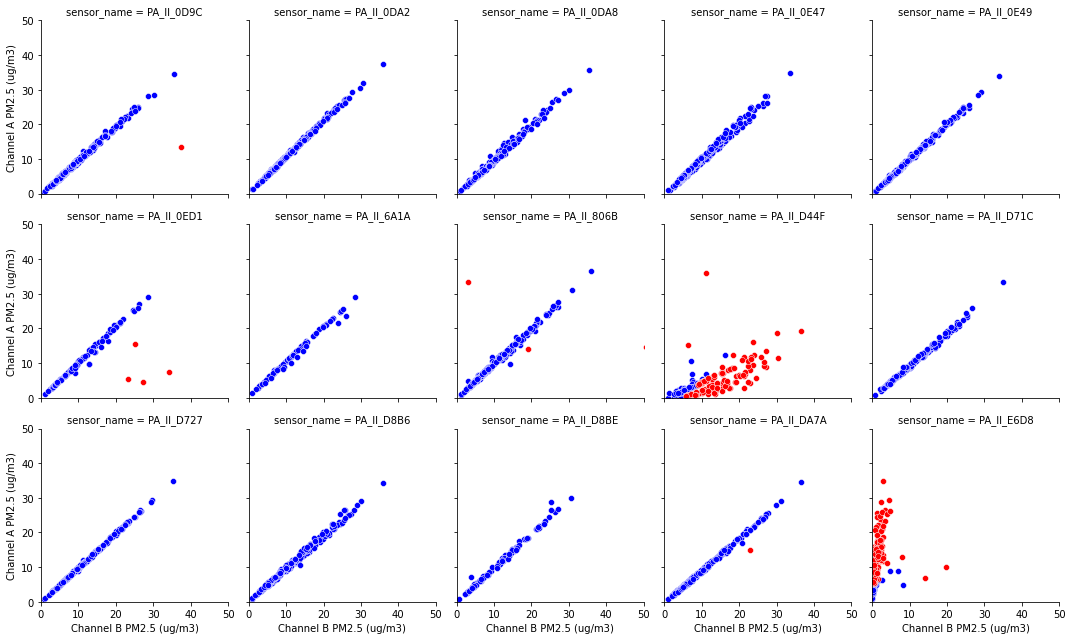

In [17]:
import matplotlib.pyplot as plt
def mark_outliers(data):
    diff =  abs(data['Channel A PM2.5 (ug/m3)']-data['Channel B PM2.5 (ug/m3)'])
    pct_error = diff*100/data['Channel A PM2.5 (ug/m3)']
    data['outlier'] = (diff > 5) & (pct_error > 16)
    return data

marked_data = mark_outliers(data)
scatter_facet_grid(marked_data, bound=70)
plt.savefig('Correlation AB.pdf',dpi=600)

## Use Seaborn to Create a Scatter Facet Grid
https://seaborn.pydata.org/tutorial/axis_grids.html


In [234]:
def remove_marked_outliers(data):
    data_cleaned = data.loc[~data.loc[:,'outlier']]
    return data_cleaned

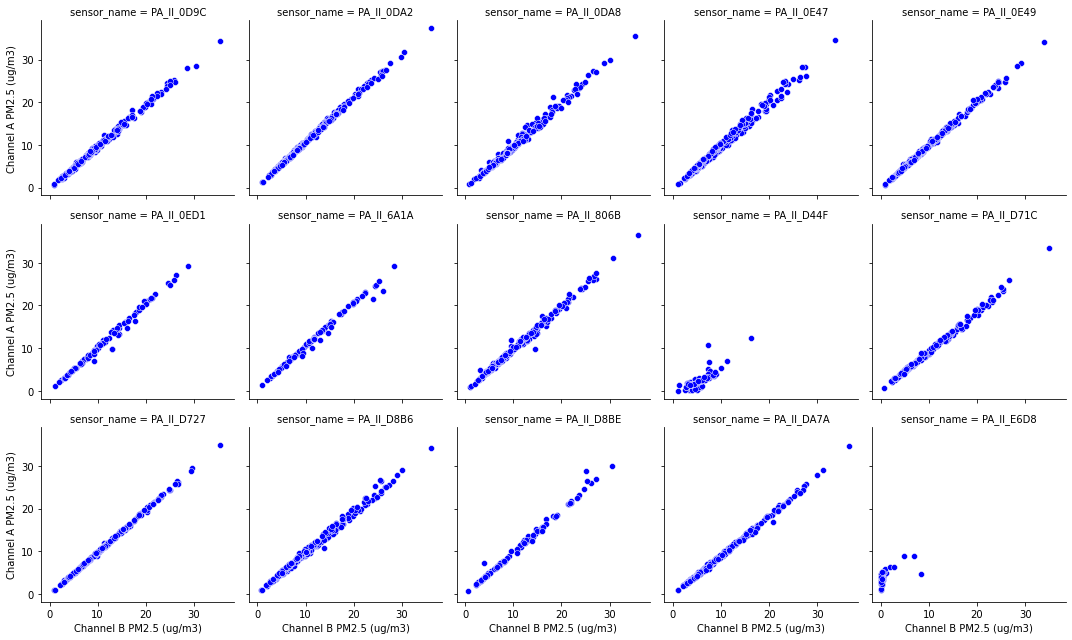

In [240]:
data_cleaned = remove_marked_outliers(data)
scatter_facet_grid(data_cleaned)


In [241]:
data_cleaned['Channel A PM2.5 (ug/m3)'].max()

3332.4488321678327